### Non-ideal reaction-diffusion systems

In the last notebook you learned the basics of phase separation driven by the competition between entropy (favoring mixing) and non-ideal interactions (favoring demixing). In this notebook you will see how first order reactions can introduce patterns of a certain length scale.

In [2]:
''' Import the packages that we need for this tutorial '''
import sys          # sys allows us to add paths to packages
import numpy as np  # numpy 
import matplotlib.pyplot as plt

#sys.path.append('../..')  # add the pde package to the python path
sys.path.append('/Users/jankirschbaum/Documents/GitHub/D2/py-pde')
import pde

We build upon the last notebook, where the concentration field $c(x,y,t)$ describes the state of the system. But now the dynamics are not given by diffusion only, instead the particles can react as well and we introduce a reactive flux $s$ that describes how many $A$ particles are created $s>0$ or destroyed $s<0$ per unit time. In this case the full dynamics are given by

\begin{align}
    \partial_t c(x,y,t) = M\nabla^2 \mu (x,y,t) + s(x,y,t)
\end{align}

where we assume a constant diffusive mobility $M$.

We assume a simple switch between the two particle types $A\rightleftharpoons B$, where $A\rightarrow B$ proceeds with rate $k_f$ and $B\rightarrow A$ with rate $k_b$. The total change of $A$ particles is then given by $s=-k_fc_A + k_bc_B=-k_fc+k_b(1-c)$, using $c_A=c$ and $c_B=1-c_A$. 

### Reactions in a homogeneous mixture

We neglect diffusion for now and discuss the reactive flux $s$ only.

### Problem 1

For constant $k_f$ and $k_b$, calculate the concentration $c_0$ for which $s(c)=-k_f c+k_b(1-c)$ vanishes. Afterwards plot $s(c)$ for $k_f=1$ and $k_b=0.3k_f$. For a given $c(t=0)$ and use it to explain the dynamics $\partial_t c = -k_f c + k_b(1-c)$.<br>
Then determine the slope $-k$ in terms of $k_f$ and $k_b$ and express $s(c)$ in terms of $k$ and $c_0$.

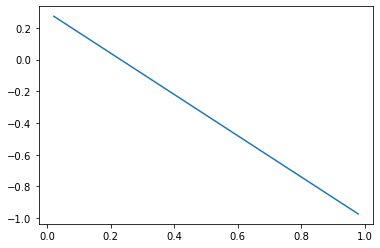

In [4]:
kf = 1
kb = 0.3*kf
c = np.linspace(0, 1)[1:-1]

plt.plot(c,-kf*c+kb*(1-c))

### Solution 1

For $c>c_0$ $s<0$ so $A$ gets destroyed until $c=c_0$, while $A$ is created for $c<c_0$, so $c_0$ is a stable fixpoint.<br>
The slope is $k=k_f+k_b$ and the flux vanishes for $c_0=k_b/(k_f+k_b)$, so $s(c) = -k(c-c_0)$.

In [3]:
# define the partial differential equation
k = 1.e-2
c0 = 0.2
eq = pde.PDE({'c': f'laplace(2 * c * (1 - c) * (1 - 2*c) - laplace(c)) + {k} * (c - {c0})'})
eq.expressions

{'c': '0.01*c + laplace(2*c*(c - 1)*(2*c - 1) - laplace(c)) - 0.002'}